# About This Notebook

### Import Libraries

In [297]:
import pandas as pd
import numpy as np

# Importing Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn Libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# SKLearn Model Libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# SKLearn Metric Libraries
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, plot_roc_curve, auc, f1_score
from sklearn import metrics

### Read in Data
* Reading in data from EDA and preprocessing notebook. It has been cleaned from stop words, symbols, numbers and contractions. 

In [235]:
posts_df = pd.read_csv('../data/preprocessed_df.csv')

In [236]:
posts_df.head(1)

,selftext,subreddit
0,resources newbie home winemaker comprehensive ...,winemaking


### Creating Target and Predictor variables. 
* X is the 'selftext' (posts) column
* Count Vectorizer expects a series object and not a dataframe object to be passed into X. 
* y is the binarized 'subreddit' column

In [237]:
X = posts_df['selftext']
y = posts_df['subreddit']

In [238]:
y = y.map({'winemaking': 1, 'Homebrewing' : 0})

In [239]:
X.shape

(4302,)

In [240]:
y.shape

(4302,)

### Train/Test/Split

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = .30, 
                                                   stratify = y, 
                                                   random_state = 42)

### Checking Mean Baseline Accuracy
#### Interpretation of baseline (below)
* Randomly guessing that a post is from Homebrewing would be right about 55% of the time. 


In [242]:
y_test.value_counts(normalize = True)

0    0.549961
1    0.450039
Name: subreddit, dtype: float64

**Notes on Baseline Hyperparameters**
* Kept min_df because I was having a problem with foreign language and couldn't get Google Translate to work so I set min_df to 2 to hopefully eliminate most, if not all, foreign words from the corpus. 

In [243]:
# Instantiate a CountVectorizer
cvec = CountVectorizer(stop_words = 'english', min_df = 2)

In [244]:
# Fit the vectorizer on our corpus Train Data. 
cvec.fit(X_train)

CountVectorizer(min_df=2, stop_words='english')

**Transforming Train and Test**

Notes on understanding fit_transform and transform
https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe

In [245]:
# Transform the corpus.
Z_train = cvec.transform(X_train)

In [246]:
#Transform but do not fit test data
Z_test = cvec.transform(X_test)

# Creating a Baseline Model
**Using Logistic Regression Classifier**

In [247]:
# Instantiate Log Reg
logr = LogisticRegression()

In [248]:
# Fit Log Reg
logr.fit(Z_train, y_train)

LogisticRegression()

In [249]:
# Score model on training set
baseline_training_score = round((logr.score(Z_train, y_train) * 100), ndigits = 1)
print(f' Score on Training Set: {baseline_training_score}%')

# Score model on testing set
baseline_test_score = round((logr.score(Z_test, y_test) * 100), ndigits = 1)
print(f' Score on Test Set: {baseline_test_score}%')

 Score on Training Set: 99.8%
 Score on Test Set: 92.5%


In [250]:
y_pred_logr = logr.predict(Z_test)

In [251]:
y_pred_logr.shape

(1291,)

In [252]:
y_pred_proba_logr = logr.predict_proba(Z_test)

In [253]:
y_pred_proba_logr.shape

(1291, 2)

In [254]:
Z_test.shape

(1291, 6554)

# Baseline Confusion Matrix

In [255]:
confusion_matrix(y_test, y_pred_logr)

array([[658,  52],
       [ 45, 536]])

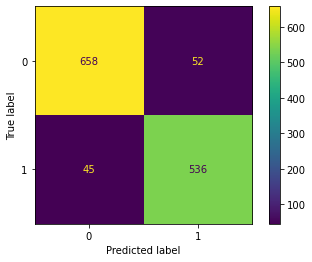

In [256]:
plot_confusion_matrix(logr, Z_test, y_test);

In [257]:
log_tn, log_fp, log_fn, log_tp = confusion_matrix(y_test, y_pred_logr).ravel()

In [258]:
print(f' True Negative = {log_tn}')
print(f' False Positive = {log_fp}')
print(f' False Negative = {log_fn}')
print(f' True Positive = {log_tp}')

 True Negative = 658
 False Positive = 52
 False Negative = 45
 True Positive = 536


# Baseline Classification Metrics

**Baseline Accuracy Score**: What percentage of observations did I correctly predict?

In [259]:
accuracy = round((accuracy_score(y_test, y_pred_logr) * 100), ndigits = 1)
print(f'Accuracy Score: {accuracy}%')

Accuracy Score: 92.5%


**Baseline Misclassification Rate:** What percentage of observations did I incorrectly prdict?

In [260]:
# I used 100 - accuracy because I multiplied up accuracy score above to convert to percentage. 
misclass_rate = round((100 - accuracy), ndigits = 3)
print(f'Misclassification Rate: {misclass_rate}%')

Misclassification Rate: 7.5%


**Baseline Sensitivity/Recall (True Positive Rate):** Among all winemaking class, how many did I get right?

In [261]:
recall_score = round((log_tp / (log_fn + log_tp) * 100) , ndigits = 1)

In [262]:
print(f'Recall Score: {recall_score}%')

Recall Score: 92.3%


**Baseline Specificity(True Negative Rate):** Among all homebrewing class, how many did I get right?

In [263]:
specificity = round((log_tn / (log_tn + log_fn) * 100), ndigits= 1)
print(f'Specificity Score: {specificity}%')

Specificity Score: 93.6%


**Baseline False Positive Rate (FPR):** the ratio of negative instances that are incorrectly classified as positive. (1 - TNR)

In [264]:
fpr = round((log_fp / (log_fp + log_tn) * 100), ndigits = 1)
print(f' False Positive Rate: {fpr}%')

 False Positive Rate: 7.3%


**Baseline Precision (Positive Predictive Value):** Among those that were predicted to be winemaking, how many were correct? This is the accuracy of the positive predictions, the percentage of correctness. This metric is typically used along with recall/sensitivity. 

In [265]:
precision = round((precision_score(y_test, y_pred_logr, pos_label = 1) * 100), ndigits = 1)
print(f'Precision Score: {precision}')

Precision Score: 91.2


**Baseline Balanced Accuracy Score:** Average of TPR and TNR (Sensitivity / Specificity / 2

In [266]:
balanced_acc = round(((recall_score / specificity) * 100), ndigits = 1)
print(f'Balanced Accuracy Score: {balanced_acc}%')

Balanced Accuracy Score: 98.6%


**Baseline F1 Score:** 

In [267]:
baseline_f1_score = round(2*((precision*recall_score)/(precision+recall_score)), ndigits = 2)
print(f'F1 Score: {baseline_f1_score}')

F1 Score: 91.75


**Baseline Classification Report:** The reported averages include macro average (averaging the unweighted mean per label), weighted average (averaging the support-weighted mean per label), and sample average (only for multilabel classification). Micro average (averaging the total true positives, false negatives and false positives) is only shown for multi-label or multi-class with a subset of classes, because it corresponds to accuracy otherwise and would be the same for all metrics. See also precision_recall_fscore_support for more details on averages.

Note that **in binary classification, recall of the positive class is also known as “sensitivity”**; **recall of the negative class is “specificity”**.

In this case the positive class is winemaking and negative class is Homebrewing. 

**F1 score** is precision and recall combined into a single metric. It is the harmonic mean of precision and recall. The classifier will only get a high F1 score if precision and recall are high. ff

In [268]:
class_report = classification_report(y_test, y_pred_logr, target_names = ['winemaking', 'Homebrewing'])
print(class_report)

              precision    recall  f1-score   support

  winemaking       0.94      0.93      0.93       710
 Homebrewing       0.91      0.92      0.92       581

    accuracy                           0.92      1291
   macro avg       0.92      0.92      0.92      1291
weighted avg       0.92      0.92      0.92      1291



# Baseline ROC/AUC

In [269]:
fpr_logr,# Baseline ROC/AUC

fpr_logr, tpr_logr, threshold = roc_curve(y_test, y_pred_logr, pos_label = 1)

**Baseline Area Under the Curve (AUC)**

In [270]:
auc1 = round((auc(fpr_logr, tpr_logr) * 100), ndigits = 1)
print(f'Baseline Area Under the Curve: {auc1}')

Baseline Area Under the Curve: 92.5


### Baseline ROC AUC Curve Using Multinomial Naive Bayes/Grid Search
Winemaking is the target variable with value = 1

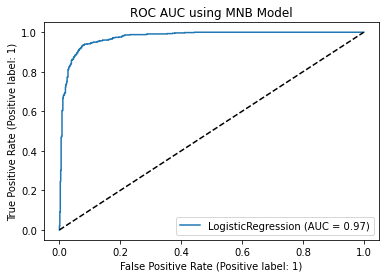

In [271]:
plot_roc_curve(logr, Z_test, y_test)
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC AUC using MNB Model');

# Running other models with default parameters to measure against the baseline. 

In [272]:
forest_clf = RandomForestClassifier(random_state=42)
svc_clf = SVC()
knn_clf = KNeighborsClassifier(n_neighbors=5)
mnb_clf = MultinomialNB()

In [273]:
classifiers = [forest_clf, svc_clf, knn_clf, mnb_clf]

In [274]:
for clf in classifiers:
    clf.fit(Z_train, y_train)
    
    # Score model on training set
    
    training_score = round((clf.score(Z_train, y_train) * 100), ndigits = 1)
        
    if clf == forest_clf:
        print(f' Random Forest Score on Training Set: {training_score}%')
    if clf == svc_clf:
        print(f' SVC Score on Training Set: {training_score}%')
    if clf == knn_clf:
        print(f' Nearest Neighbors Score on Training Set: {training_score}%')
    if clf == mnb_clf:
        print(f' Naive Bayes Score on Training Set: {training_score}%')
        
        

    # Score model on testing set
    test_score = round((clf.score(Z_test, y_test) * 100), ndigits = 1)
        
    if clf == forest_clf:
        print(f' Random Forest Score on Testing Set: {test_score}%')
    if clf == svc_clf:
        print(f' SVC Score on Testing Set: {test_score}%')
    if clf == knn_clf:
        print(f' Nearest Neighbors Score on Testing Set: {test_score}%')
    if clf == mnb_clf:
        print(f' Naive Bayes Score on Testing Set: {test_score}%')
        print(f' Baseline Score on Training Set: {baseline_training_score}')
        print(f'Baseline Score on Testing Set: {baseline_test_score}')


 Random Forest Score on Training Set: 99.9%
 Random Forest Score on Testing Set: 92.7%
 SVC Score on Training Set: 96.3%
 SVC Score on Testing Set: 89.9%
 Nearest Neighbors Score on Training Set: 85.9%
 Nearest Neighbors Score on Testing Set: 76.7%
 Naive Bayes Score on Training Set: 95.2%
 Naive Bayes Score on Testing Set: 91.7%
 Baseline Score on Training Set: 99.8
Baseline Score on Testing Set: 92.5


**Create Y Preds**

In [275]:
y_pred_forest = forest_clf.predict(Z_test)
y_pred_svc = svc_clf.predict(Z_test)
y_pred_knn = knn_clf.predict(Z_test)
y_pred_mnb = mnb_clf.predict(Z_test)

In [276]:
preds_list = [y_pred_forest, y_pred_svc, y_pred_knn, y_pred_mnb]

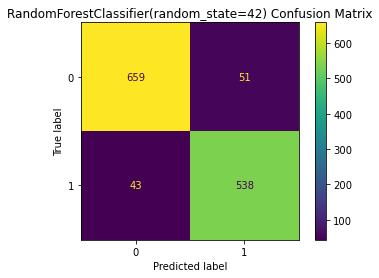

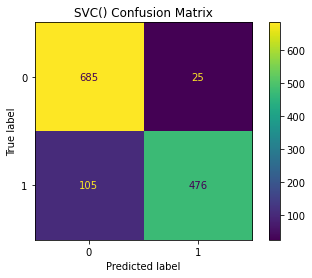

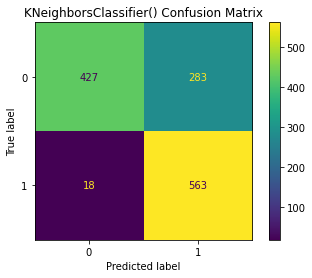

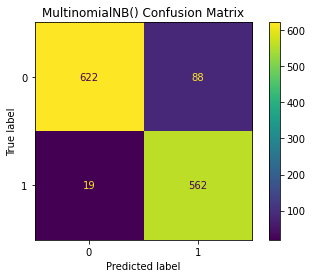

In [307]:
for clf in classifiers:
    title = f'{clf} Confusion Matrix'
    plot_confusion_matrix(clf, Z_test, y_test)
    plt.title(title);

In [278]:
def clf_metric_scorer(clf_list):
    
    ## Creating Lists to Populate with Scores
    classifier_list = []
    tn_list = []
    fp_list = []
    fn_list = []
    tp_list = []
    acc_list = []
    miss_list = []
    recall_list = []
    spec_list = []
    fpr_list = []
    prec_list = []
    bal_acc_list = []
    f1_score_list = []


    
    for clf in clf_list:
        
        ## for classifier identification column in new DF ##
        classifier_list.append(str(clf))
        
        ## Fit Classifiers ##
        clf.fit(Z_train, y_train)
        
        ## Create Predictions ##
        preds = clf.predict(Z_test)
        
        ## Confusion Matrix ##
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
            
        tn_list.append(tn)
        fp_list.append(fp)
        fn_list.append(fn)
        tp_list.append(tp)
             
        ## Accuracy ##
        accuracy = round((accuracy_score(y_test, preds) * 100), ndigits = 1)
            
        acc_list.append(accuracy)
            
        ## Misclassification rate ##
        misclass_rate = round((100 - accuracy), ndigits = 3)
            
        miss_list.append(misclass_rate)
            
        ## Recall ##
        recall_score = round((tp / (fn + tp) * 100) , ndigits = 1)
            
        recall_list.append(recall_score)
            
        ## Specificity ##
        specificity = round((tn / (tn + fn) * 100), ndigits= 1)
            
        spec_list.append(specificity)
            
        ## False Positive Rate ##
        fpr = round((fp / (fp + tn) * 100), ndigits = 1)
            
        fpr_list.append(fpr)
            
        ## Precision ##
        precision = round((precision_score(y_test, preds, pos_label = 1) * 100), ndigits = 1)
            
        prec_list.append(precision)
            
        ## Balanced Accuracy Score ##
        balanced_acc = round((recall_score / specificity), ndigits = 3)
            
        bal_acc_list.append(balanced_acc)
        
        ## F1 Score ##
        f1_score = round(2*((precision*recall_score)/(precision+recall_score)), ndigits = 2)
        
        f1_score_list.append(f1_score)
    
    ### Create a Dictionary to be turned into a DF ###
    score_dict = {'clf': classifier_list, 'tn' : tn_list , 'fp' : fp_list, 'fn' : fn_list, 
              'tp' : tp_list , 'accuracy' : acc_list , 'misclass' : miss_list ,
              'recall' : recall_list , 'specificity' : spec_list , 'fpr' : fpr_list, 
              'precision' : prec_list, 'balanced_acc' : bal_acc_list, 'f1_score': f1_score_list}
    
    ### DataFrame Instantiation ###
    metric_df = pd.DataFrame(score_dict)
    
    return metric_df

**Call clf_metric_scorer fuction and name the resulting DF**

In [279]:
clf_metric_scores = clf_metric_scorer(classifiers)

In [280]:
clf_metric_scores

,clf,tn,fp,fn,tp,accuracy,misclass,recall,specificity,fpr,precision,balanced_acc,f1_score
0,RandomForestClassifier(random_state=42),659,51,43,538,92.7,7.3,92.6,93.9,7.2,91.3,0.986,91.95
1,SVC(),685,25,105,476,89.9,10.1,81.9,86.7,3.5,95.0,0.945,87.96
2,KNeighborsClassifier(),427,283,18,563,76.7,23.3,96.9,96.0,39.9,66.5,1.009,78.87
3,MultinomialNB(),622,88,19,562,91.7,8.3,96.7,97.0,12.4,86.5,0.997,91.32


**ADDING BASELINE METRICS TO METRIC SCORES DF**

In [281]:
baseline_metrics = {'clf': 'Baseline Log Reg', 'tn' : log_tn , 'fp' : log_fp, 'fn' : log_fn, 
              'tp' : log_tp , 'accuracy' : accuracy , 'misclass' : misclass_rate,
              'recall' : recall_score , 'specificity' : specificity , 'fpr' : fpr, 
              'precision' : precision, 'balanced_acc' : balanced_acc, 'f1_score': baseline_f1_score}

In [282]:
clf_metric_scores = clf_metric_scores.append(baseline_metrics, ignore_index = True)

**Cleaning Up Clf Column Labels**

In [283]:
clf_values = ['Random Forest', 'SVC', 'KNN', 'Naive Bayes', 'Baseline Log Reg']
clf_metric_scores['clf'] = clf_values

**Setting clf column as index**

In [284]:
clf_metric_scores.set_index('clf', inplace = True)

In [285]:
clf_metric_scores

,tn,fp,fn,tp,accuracy,misclass,recall,specificity,fpr,precision,balanced_acc,f1_score
clf,,,,,,,,,,,,
Random Forest,659,51,43,538,92.7,7.3,92.6,93.9,7.2,91.3,0.986,91.95
SVC,685,25,105,476,89.9,10.1,81.9,86.7,3.5,95.0,0.945,87.96
KNN,427,283,18,563,76.7,23.3,96.9,96.0,39.9,66.5,1.009,78.87
Naive Bayes,622,88,19,562,91.7,8.3,96.7,97.0,12.4,86.5,0.997,91.32
Baseline Log Reg,658,52,45,536,92.5,7.5,92.3,93.6,7.3,91.2,98.600,91.75


# Comparing ROC/AUC

                                              AUC
RandomForestClassifier(random_state=42)  0.927079
SVC()                                    0.892033
KNeighborsClassifier()                   0.785214
MultinomialNB()                          0.921677


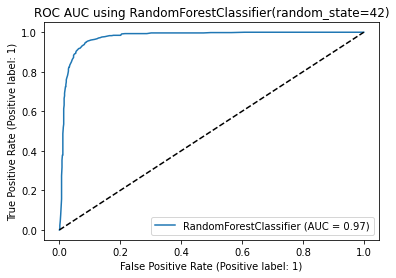

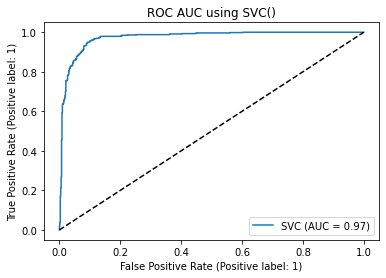

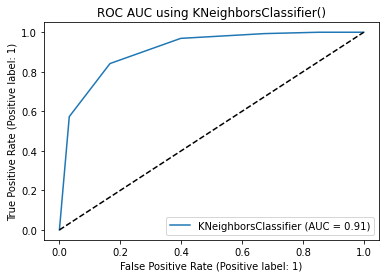

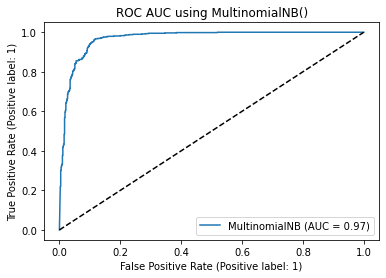

In [306]:
auc_list = []
classifier_list = []

for clf in classifiers:
    
    ## for classifier identification column in new DF ##
    classifier_list.append(str(clf))
    
    ## Fit Classifiers ##
    clf.fit(Z_train, y_train)
        
    ## Create Predictions ##
    pred = clf.predict(Z_test)
        
    fpr, tpr, threshold = roc_curve(y_test, pred, pos_label = 1)
        
    auc = metrics.auc(fpr, tpr)
    auc_list.append(auc)
        
    plot_roc_curve(clf, Z_test, y_test)
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'ROC AUC using {clf}')
    

auc_df = pd.DataFrame(auc_list, index = classifier_list, columns = ['AUC'])
print(auc_df)

The ideal ROC curve hugs the top left corner, indicating a high true positive
rate and a low false positive rate. The dotted line represents the “no information”
classifier; this is what we would expect if student status and credit card balance
are not associated with probability of default. (from page 148 Statistical Learning)
* http://www.ime.unicamp.br/~dias/Intoduction%20to%20Statistical%20Learning.pdf
    